In [ ]:
import transformers
print(transformers.__version__)

4.53.3


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
zip_path = '/content/drive/MyDrive/image/Potato Leaf Disease Dataset in Uncontrolled Environment.zip'
extract_path = '/content/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction complete!")

Extraction complete!


In [ ]:
dataset_path = '/content/Potato Leaf Disease Dataset in Uncontrolled Environment'

In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import timm
import os
import shutil
import torch.nn.functional as F
import numpy as np
from sklearn.model_selection import KFold
from timm.data.mixup import Mixup
from timm.models import vit_base_patch16_224
from timm.loss import SoftTargetCrossEntropy
from torch.optim.lr_scheduler import CosineAnnealingLR, LinearLR, SequentialLR
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Config
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
NUM_CLASSES = 7
BATCH_SIZE = 64  # Keep this even (64 is fine)
EPOCHS = 100
LR = 2e-5
WEIGHT_DECAY = 0.01
DROPOUT = 0.3
LABEL_SMOOTHING = 0.1
MIXUP_ALPHA = 0.3
CUTMIX_ALPHA = 1.0

In [ ]:
from sklearn.model_selection import train_test_split

def split_images(dataset_dir, output_dir, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    class_names = os.listdir(dataset_dir)
    for class_name in class_names:
        class_path = os.path.join(dataset_dir, class_name)
        if not os.path.isdir(class_path): continue

        images = os.listdir(class_path)
        train, temp = train_test_split(images, test_size=(1-train_ratio), random_state=42)
        val, test = train_test_split(temp, test_size=test_ratio/(test_ratio+val_ratio), random_state=42)

        for split_name, split_data in zip(['train', 'val', 'test'], [train, val, test]):
            split_dir = os.path.join(output_dir, split_name, class_name)
            os.makedirs(split_dir, exist_ok=True)
            for img_file in split_data:
                src = os.path.join(class_path, img_file)
                dst = os.path.join(split_dir, img_file)
                shutil.copy(src, dst)

# Jalankan split
split_images(dataset_path, '/content/potato_split')

In [ ]:
# Augmentations
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 0.5)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
# Dataset
train_dataset = datasets.ImageFolder('/content/potato_split/train', transform=train_transform)
val_dataset = datasets.ImageFolder('/content/potato_split/val', transform=val_transform)

# Class Balance Weighting
class_counts = np.bincount(train_dataset.targets)
class_weights = torch.Tensor((1. / class_counts) * (class_counts.sum() / NUM_CLASSES)).to(DEVICE)

# Model
model = timm.create_model('vit_base_patch16_224_in21k', pretrained=True, num_classes=NUM_CLASSES, drop_rate=DROPOUT)
model.head = nn.Sequential(
    nn.LayerNorm(model.head.in_features),
    nn.Dropout(DROPOUT),
    nn.Linear(model.head.in_features, NUM_CLASSES)
)
model.to(DEVICE)

/usr/local/lib/python3.11/dist-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name vit_base_patch16_224_in21k to current vit_base_patch16_224.augreg_in21k.
  model = create_fn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/410M [00:00<?, ?B/s]

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False

In [ ]:
# Loss & Optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

# Scheduler with Warmup
scheduler_warmup = LinearLR(optimizer, start_factor=0.01, total_iters=5)
scheduler_cosine = CosineAnnealingLR(optimizer, T_max=EPOCHS-5)
scheduler = SequentialLR(optimizer, schedulers=[scheduler_warmup, scheduler_cosine], milestones=[5])

In [ ]:
# MixUp - with proper initialization
mixup_args = {
    'mixup_alpha': MIXUP_ALPHA,
    'cutmix_alpha': CUTMIX_ALPHA,
    'prob': 0.6,
    'switch_prob': 0.5,
    'mode': 'batch',
    'label_smoothing': LABEL_SMOOTHING,
    'num_classes': NUM_CLASSES
}
mixup_fn = Mixup(**mixup_args)

In [ ]:
# DataLoaders - ensure drop_last=True for training
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    drop_last=True  # This ensures batch size is always even
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4
)

In [ ]:
# Training Loop
best_val_acc = 0
for epoch in range(EPOCHS):
    # Training
    model.train()
    train_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        # Apply mixup
        if np.random.rand() < mixup_args['prob']:
            inputs, labels = mixup_fn(images, labels)
        else:
            inputs = images

        optimizer.zero_grad()
        outputs = model(inputs)

        # Calculate loss
        if isinstance(labels, tuple):  # For CutMix
            labels1, labels2, lam = labels
            loss = lam * criterion(outputs, labels1) + (1 - lam) * criterion(outputs, labels2)
        elif labels.dim() == 2:  # For MixUp (probability distribution)
            loss = torch.sum(-labels * F.log_softmax(outputs, dim=-1), dim=-1).mean()
        else:  # Regular labels
            loss = criterion(outputs, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        train_loss += loss.item()

    scheduler.step()

    # Validation
    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Metrics
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    val_acc = correct / total

    print(f"Epoch {epoch+1}/{EPOCHS} | "
          f"Train Loss: {train_loss:.4f} | "
          f"Val Loss: {val_loss:.4f} | "
          f"Val Acc: {val_acc:.4f}")

    # Save Best Model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"New best model saved! Acc: {best_val_acc:.4f}")

print(f"\nTraining Complete! Best Val Acc: {best_val_acc:.4f}")

Epoch 1/100 | Train Loss: 2.0747 | Val Loss: 2.0023 | Val Acc: 0.2029
New best model saved! Acc: 0.2029
Epoch 2/100 | Train Loss: 1.8697 | Val Loss: 1.5147 | Val Acc: 0.4740
New best model saved! Acc: 0.4740
Epoch 3/100 | Train Loss: 1.5077 | Val Loss: 0.9486 | Val Acc: 0.6591
New best model saved! Acc: 0.6591
Epoch 4/100 | Train Loss: 1.1555 | Val Loss: 0.5623 | Val Acc: 0.8133
New best model saved! Acc: 0.8133


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 5/100 | Train Loss: 0.8309 | Val Loss: 0.4007 | Val Acc: 0.8636
New best model saved! Acc: 0.8636
Epoch 6/100 | Train Loss: 0.7294 | Val Loss: 0.3279 | Val Acc: 0.8815
New best model saved! Acc: 0.8815
Epoch 7/100 | Train Loss: 0.7088 | Val Loss: 0.3175 | Val Acc: 0.8766
Epoch 8/100 | Train Loss: 0.7876 | Val Loss: 0.3084 | Val Acc: 0.8766
Epoch 9/100 | Train Loss: 0.6586 | Val Loss: 0.3165 | Val Acc: 0.8961
New best model saved! Acc: 0.8961
Epoch 10/100 | Train Loss: 0.7201 | Val Loss: 0.3256 | Val Acc: 0.8782
Epoch 11/100 | Train Loss: 0.6239 | Val Loss: 0.2977 | Val Acc: 0.8994
New best model saved! Acc: 0.8994
Epoch 12/100 | Train Loss: 0.6181 | Val Loss: 0.3079 | Val Acc: 0.9026
New best model saved! Acc: 0.9026
Epoch 13/100 | Train Loss: 0.7006 | Val Loss: 0.2819 | Val Acc: 0.9010
Epoch 14/100 | Train Loss: 0.5719 | Val Loss: 0.2711 | Val Acc: 0.9091
New best model saved! Acc: 0.9091
Epoch 15/100 | Train Loss: 0.5570 | Val Loss: 0.2870 | Val Acc: 0.9140
New best model saved

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

def evaluate_model(model, dataloader, class_names):
    model.eval()
    all_preds = []
    all_probs = []
    all_targets = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            probs = F.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            all_probs.append(probs.cpu())
            all_preds.append(preds.cpu())
            all_targets.append(labels.cpu())

    # Concatenate all batches
    all_probs = torch.cat(all_probs).numpy()
    all_preds = torch.cat(all_preds).numpy()
    all_targets = torch.cat(all_targets).numpy()

    # 1. Classification Report
    print("Classification Report:")
    print(classification_report(all_targets, all_preds, target_names=class_names))

    # 2. Confusion Matrix
    cm = confusion_matrix(all_targets, all_preds)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # 3. ROC AUC (One-vs-Rest for multiclass)
    if NUM_CLASSES > 2:
        # Binarize the output
        y_true_bin = label_binarize(all_targets, classes=range(NUM_CLASSES))

        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(NUM_CLASSES):
            fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], all_probs[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), all_probs.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        # Plot ROC curves
        plt.figure(figsize=(10,8))
        for i in range(NUM_CLASSES):
            plt.plot(fpr[i], tpr[i],
                     label='ROC curve of class {0} (area = {1:0.2f})'
                     ''.format(class_names[i], roc_auc[i]))

        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves (One-vs-Rest)')
        plt.legend(loc="lower right")
        plt.show()

        print(f"\nAverage ROC AUC Score: {np.mean(list(roc_auc.values())):.4f}")
    else:
        fpr, tpr, _ = roc_curve(all_targets, all_probs[:, 1])
        roc_auc = auc(fpr, tpr)

        plt.figure()
        plt.plot(fpr, tpr, color='darkorange',
                 label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc="lower right")
        plt.show()

    return all_probs, all_preds, all_targets

Classification Report:
              precision    recall  f1-score   support

    Bacteria       0.99      0.99      0.99       114
       Fungi       0.91      0.89      0.90       150
     Healthy       1.00      0.90      0.95        40
    Nematode       0.85      0.79      0.81        14
        Pest       0.89      0.90      0.90       122
 Phytopthora       0.91      0.91      0.91        70
       Virus       0.92      0.97      0.94       106

    accuracy                           0.93       616
   macro avg       0.92      0.91      0.92       616
weighted avg       0.93      0.93      0.93       616



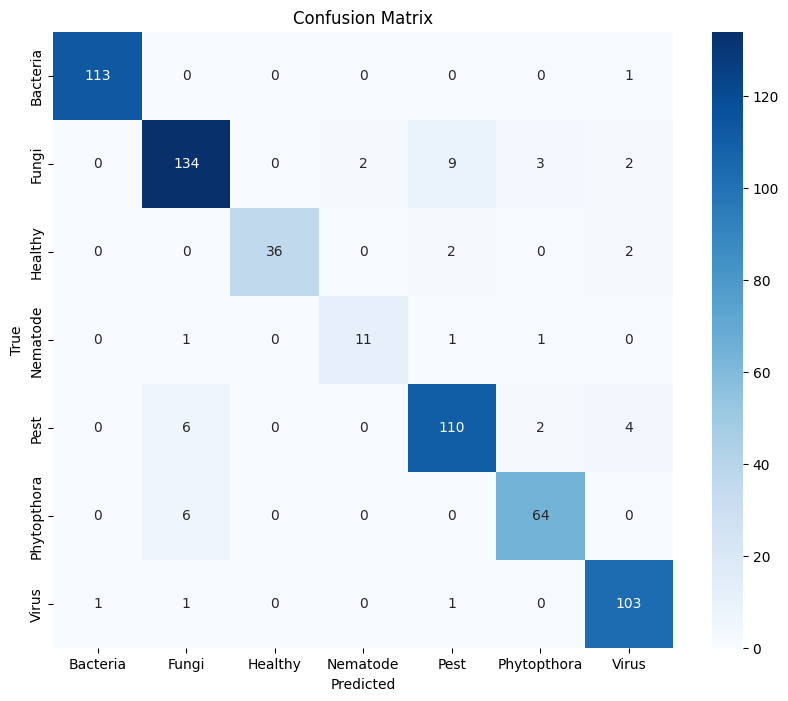

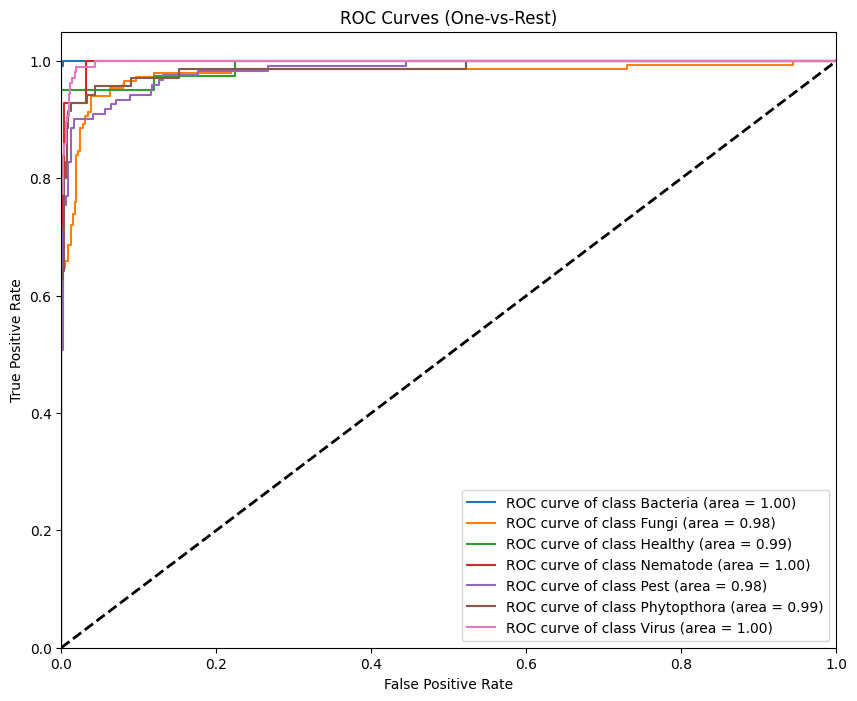


Average ROC AUC Score: 0.9907


In [ ]:
class_names = train_dataset.classes
val_probs, val_preds, val_targets = evaluate_model(model, val_loader, class_names)

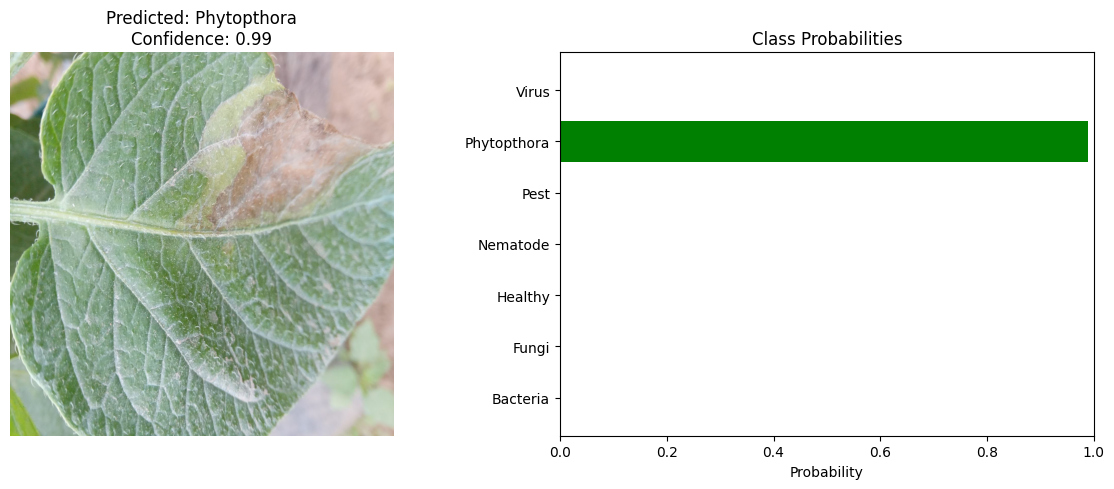


Final Prediction: Phytopthora with 98.9% confidence


In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch

def predict_single_image(model, image_path, class_names, transform):
    """
    Predict class for a single image with visualization

    Args:
        model: Trained model
        image_path: Path to image file
        class_names: List of class names
        transform: Image transforms to apply
    """
    # Load and preprocess image
    img = Image.open(image_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0).to(DEVICE)  # Add batch dimension

    # Make prediction
    model.eval()
    with torch.no_grad():
        outputs = model(img_tensor)
        probs = F.softmax(outputs, dim=1)
        conf, preds = torch.max(probs, 1)

    # Convert to numpy
    img_np = np.array(img)
    probs = probs.cpu().numpy().flatten()

    # Visualization
    plt.figure(figsize=(12, 5))

    # Show image
    plt.subplot(1, 2, 1)
    plt.imshow(img_np)
    plt.title(f"Predicted: {class_names[preds.item()]}\nConfidence: {conf.item():.2f}")
    plt.axis('off')

    # Show probabilities
    plt.subplot(1, 2, 2)
    colors = ['green' if i == preds.item() else 'gray' for i in range(len(class_names))]
    plt.barh(class_names, probs, color=colors)
    plt.xlim(0, 1)
    plt.title('Class Probabilities')
    plt.xlabel('Probability')
    plt.tight_layout()
    plt.show()

    return class_names[preds.item()], conf.item()

# Example usage:
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class_names = train_dataset.classes  # Get from your dataset
image_path = "/content/potato_split/test/Phytopthora/20230802_123436584.jpg"  # Replace with your image path

pred_class, confidence = predict_single_image(
    model=model,
    image_path=image_path,
    class_names=class_names,
    transform=test_transform
)

print(f"\nFinal Prediction: {pred_class} with {confidence*100:.1f}% confidence")


Evaluated 311 images across 7 classes

=== Classification Report ===
              precision    recall  f1-score   support

    Bacteria       0.98      1.00      0.99        57
       Fungi       0.91      0.89      0.90        75
     Healthy       0.79      0.90      0.84        21
    Nematode       0.78      1.00      0.88         7
        Pest       0.95      0.92      0.93        62
 Phytopthora       0.91      0.91      0.91        35
       Virus       0.96      0.91      0.93        54

    accuracy                           0.93       311
   macro avg       0.90      0.93      0.91       311
weighted avg       0.93      0.93      0.93       311


=== Accuracy per Class ===
Bacteria: 100.00%
Fungi: 89.33%
Healthy: 90.48%
Nematode: 100.00%
Pest: 91.94%
Phytopthora: 91.43%
Virus: 90.74%


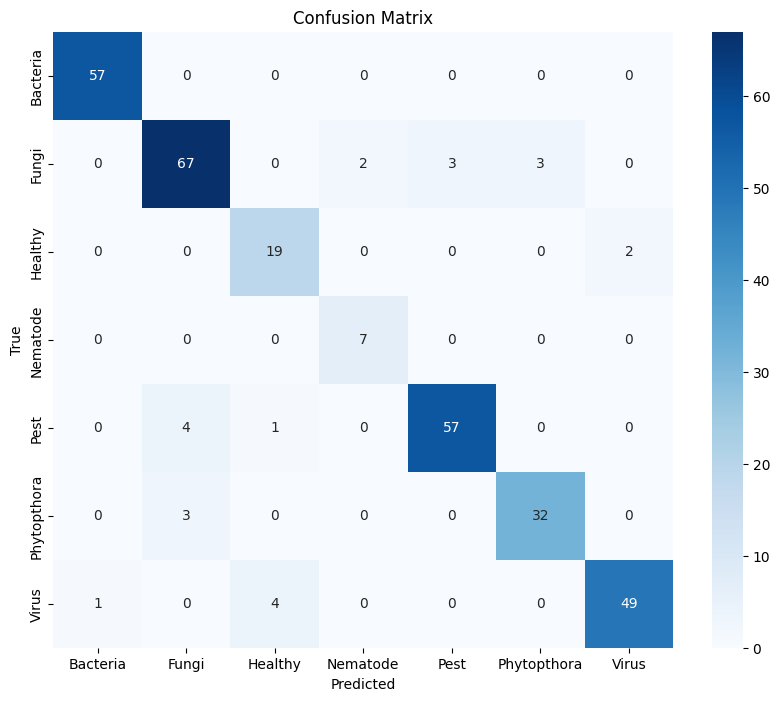

In [ ]:
import os
from PIL import Image
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_test_folder(model, test_folder_path, class_names, transform):
    """
    Evaluate model on test folder with subfolders for each class

    Args:
        model: Trained model
        test_folder_path: Path to test folder (with subfolders for each class)
        class_names: List of class names (must match subfolder names)
        transform: Image transforms to apply
    """
    model.eval()
    true_labels = []
    pred_labels = []
    image_count = 0

    # Verify folder structure
    if not os.path.exists(test_folder_path):
        raise ValueError(f"Test folder not found at {test_folder_path}")

    # Iterate through each class folder
    for class_idx, class_name in enumerate(class_names):
        class_path = os.path.join(test_folder_path, class_name)
        if not os.path.isdir(class_path):
            print(f"Warning: Class folder {class_name} not found, skipping")
            continue

        # Process each image in class folder
        for img_file in os.listdir(class_path):
            if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                try:
                    img_path = os.path.join(class_path, img_file)
                    img = Image.open(img_path).convert('RGB')
                    img_tensor = transform(img).unsqueeze(0).to(DEVICE)

                    # Predict
                    with torch.no_grad():
                        outputs = model(img_tensor)
                        _, pred = torch.max(outputs, 1)

                    true_labels.append(class_idx)
                    pred_labels.append(pred.item())
                    image_count += 1
                except Exception as e:
                    print(f"Error processing {img_path}: {str(e)}")

    if image_count == 0:
        raise ValueError(f"No valid images found in {test_folder_path}")

    # Convert to numpy arrays
    true_labels = np.array(true_labels)
    pred_labels = np.array(pred_labels)

    # Calculate accuracy per class
    class_acc = {}
    for i, class_name in enumerate(class_names):
        class_mask = true_labels == i
        if np.sum(class_mask) > 0:  # Only calculate if samples exist
            correct = np.sum(pred_labels[class_mask] == true_labels[class_mask])
            total = np.sum(class_mask)
            class_acc[class_name] = (correct / total) * 100

    # Generate confusion matrix
    cm = confusion_matrix(true_labels, pred_labels, labels=range(len(class_names)))

    # Print results
    print(f"\nEvaluated {image_count} images across {len(class_names)} classes")
    print("\n=== Classification Report ===")
    print(classification_report(true_labels, pred_labels,
                              target_names=class_names,
                              labels=range(len(class_names)),
                              zero_division=0))

    print("\n=== Accuracy per Class ===")
    for class_name in class_names:
        acc = class_acc.get(class_name, 0)
        print(f"{class_name}: {acc:.2f}%")

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return class_acc, cm

# Example usage:
test_folder_path = "/content/potato_split/test"  # Update this path
class_names = sorted(os.listdir(test_folder_path))  # Auto-detect classes from folder

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

try:
    class_acc, confusion_mat = evaluate_test_folder(
        model=model,
        test_folder_path=test_folder_path,
        class_names=class_names,
        transform=test_transform
    )
except Exception as e:
    print(f"Evaluation failed: {str(e)}")
    print("Please check:")
    print(f"1. Test folder exists at {test_folder_path}")
    print(f"2. It contains subfolders for each class")
    print(f"3. Each subfolder contains images (.jpg/.png)")

In [ ]:
!cp /content/best_model.pth /content/drive/MyDrive/iseng/